# Explainable Deep Time Series Classification

This notebook presents selected methods for explaining predictions made by a deep neural network based speech classification model. 

In the recent years the need for an explainable Machine Learning has increased drastically. This need is particualrly important when it comes to the ML models that belongs to the class of Deep Neural Networks. The reason for that is that, unlike simpler method such as Linear/Logistic regression or Decision Trees, Neural Networks are largely treated as "Black-Boxes" - systems whose inner structure remains a mystery and we can only characterize them by studying input and outputs. This is problematic, because DNNs are responsible for many breaktroughs in Natural Language Processing, Image Recognition, Speech Recogntion and many more. For some fields (like medicine), however, this lack of transparency is crucial.

Where there is a need, there is progress. A lot of framewroks that ease research on this issue have emarged, most notably SHAP https://github.com/slundberg/shap and https://github.com/marcotcr/lime. 

A particualrily interesting project was developed aiming at explaining predictions made by those Black-boxes - Deep Neural Networks. It is called Captum -> https://github.com/pytorch/captum and is a part of PyTorch - one of the most Deep Learing frameworks, with ~40k stars on GiHub and a growing community of both researchers and engineers. It is also my framework of choice for Deep Learning.

Captum features:
* out of the box support for any PyTorch model
* rich documentation and tutorials
* integration of many different, more and less popular explaination methods, such as Integrated Gradients, Feature Ablation, Gradient SHAP and many others

In [1]:
# this notebook expects the ftdnn module to be installed in your virtual environment
import os

import numpy as np
import torch
import torch.nn as nn
import captum
from captum.attr import IntegratedGradients, FeatureAblation
import matplotlib.pyplot as plt
from matplotlib import cm

import ftdnn

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

# Classification problem description


In [3]:
class AgeBackend(nn.Module):

    def __init__(self, embedding_size: int = 512, num_classes: int = 2, mode: str = 'softmax'):
        super().__init__()
        self.layer01 = ftdnn.DenseReLU(embedding_size, embedding_size)
        if mode == 'softmax':
            self.layer02 = ftdnn.DenseSoftmax(embedding_size, num_classes)
        elif mode == 'logits':
            self.layer02 = ftdnn.DenseLogits(embedding_size, num_classes)
        else:
            raise ValueError('Unrecogonized mode {}'.format(mode))

    def forward(self, x):
        x = self.layer01(x)
        x = self.layer02(x)
        return x
    
class TDNNXVectorAgeClassifierPytorch(nn.Module):

    def __init__(self, tdnn_params, classifier_params):
        super(TDNNXVectorAgeClassifierPytorch, self).__init__()
        self.tdnn = ftdnn.TDNN(tdnn_params.get('in_dim', 30))
        self.classifier = AgeBackend(
            classifier_params.get('embedding_size', 512), 
            classifier_params.get('num_classes', 8), 
            classifier_params.get('mode', 'softmax')
        )

    def forward(self, audio_features):
        # ftdnn needs data in BatchTag, ProcessedTimeTag, MFCCSignalTag
        audio_features = torch.transpose(audio_features, 1, 2)
        embedding = self.tdnn(audio_features)
        outputs = self.classifier(embedding)
        return outputs

def from_categorical(y: np.ndarray) -> np.uint8:
    """Return num class from one hot encoded tensor i.e. [0, 0, 1, 0] will return 2 """
    return np.argmax(y)
    
def __gather_predicted_classes(predictions_list: list, labels: list) -> list:
    results = []
    labels_map = dict([(i, labels[i]) for i in range(len(labels))])
    for prediction in predictions_list:
        if len(labels) == 2:
            prediction_lc = np.round(prediction.float().cpu().numpy())[0].astype(np.int)
        elif len(labels) > 2:
            prediction_lc = from_categorical(prediction.cpu().numpy())
        else:
            raise ValueError('Invalid labels length {}'.format(len(labels)))
        results.append(labels_map[prediction_lc])

    return results
    
def post_process_predictions(predictions_list: list, labels: list) -> list:
    return __gather_predicted_classes(predictions_list, labels)

In [13]:
pytorch_embedder = TDNNXVectorAgeClassifierPytorch(
    tdnn_params={
        'in_dim': 30,
    },
    classifier_params={
        'embedding_size': 512,
        'num_classes': 8,
        'mode': 'logits'
    }
)

In [14]:
checkpoint_dir = 'pretrained_models/tdnn/checkpoint.pt'
pytorch_embedder.load_state_dict(torch.load(checkpoint_dir))
pytorch_embedder.eval()

TDNNXVectorAgeClassifierPytorch(
  (tdnn): TDNN(
    (frame1): TDNNLayer(
      (kernel): Conv1d(30, 512, kernel_size=(5,), stride=(1,))
      (nonlinearity): ReLU()
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (frame2): TDNNLayer(
      (kernel): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,))
      (nonlinearity): ReLU()
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (frame3): TDNNLayer(
      (kernel): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(3,))
      (nonlinearity): ReLU()
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (frame4): TDNNLayer(
      (kernel): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
      (nonlinearity): ReLU()
      (bn): BatchNorm

In [11]:
def load_wavs():
    wavs = []
    wavs_dir = 'data/wavs'
    wavs_filenames = [filename for filename in os.listdir(wavs_dir) if 'wav' in filename]
    for wav_filename in wavs_filenames:
        wavs.append((wav_filename, np.load(os.path.join(wavs_dir, wav_filename))))
    return wavs

def load_mfccs():
    mfccs = []
    mfccs_dir = 'data/mfccs'
    mfccs_filenames = [filename for filename in os.listdir(mfccs_dir) if 'mfcc' in filename]
    for mfcc_filename in mfccs_filenames:
        mfccs.append((mfcc_filename, np.load(os.path.join(mfccs_dir, mfcc_filename))))
    return mfccs

def load_classes():
    classes = []
    classes_dir = 'data/classes'
    classes_filenames = [filename for filename in os.listdir(classes_dir) if 'class' in filename]
    for class_filename in classes_filenames:
        classes.append((class_filename, np.load(os.path.join(classes_dir, class_filename))))
    return classes

def get_real_class(name):
    return name.split('_')[1].split('.')[0]

wav_eighties.npy mfcc_eighties.npy
network prediction: [[ 3.0646107   0.8872832  -2.4843242  -1.4130279  -5.3649225  -0.03986621
   2.8079686   2.5553827 ]]
predicted: ['teens'], real class: eighties


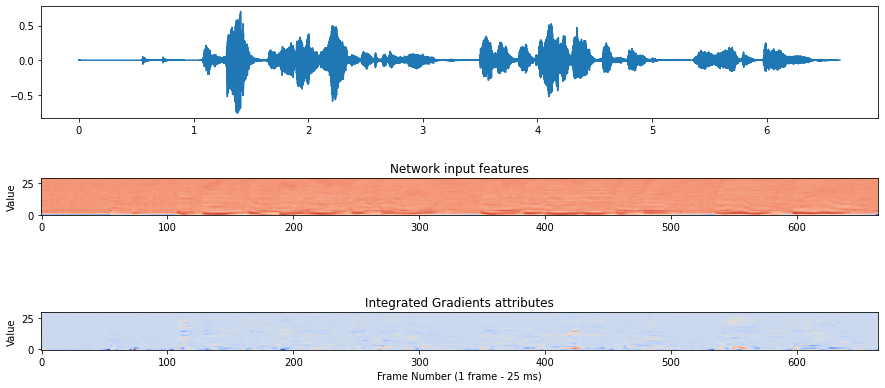

wav_fifties.npy mfcc_fifties.npy
network prediction: [[  0.33479452 -49.401745    11.8042965   -4.1163297   37.033962
   -0.7913718    3.026516     2.1084814 ]]
predicted: ['fifties'], real class: fifties


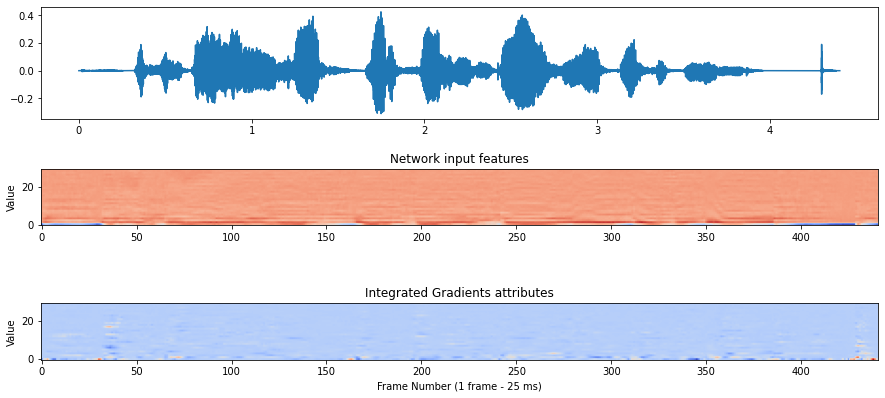

wav_fourties.npy mfcc_fourties.npy
network prediction: [[ -9.902435   -7.973635   -8.739233   40.352825   -3.5192795 -13.082677
    5.507105   -2.6514864]]
predicted: ['fourties'], real class: fourties


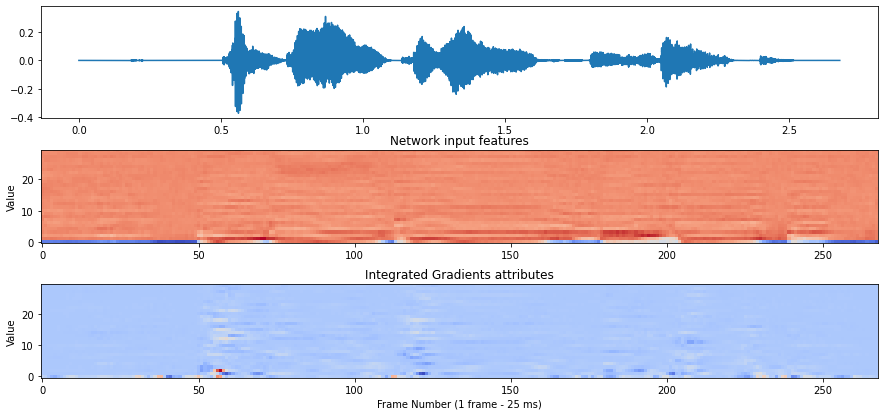

wav_seventies.npy mfcc_seventies.npy
network prediction: [[ 10.329803   -25.87305    -37.03365      0.33786795 -13.011906
    6.6826086   47.669216    10.880729  ]]
predicted: ['seventies'], real class: seventies


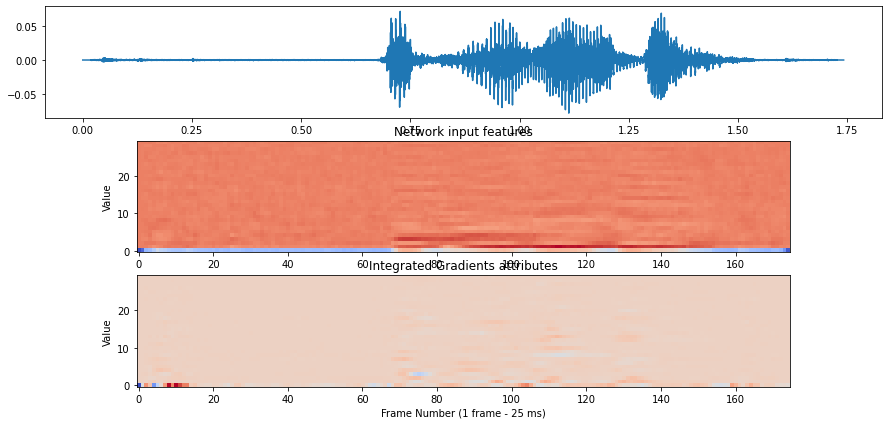

wav_sixties.npy mfcc_sixties.npy
network prediction: [[ -0.6358677  -0.6150241 -14.509293   -2.3809507  -0.9701512  20.12123
   -2.9505682   1.9456484]]
predicted: ['sixties'], real class: sixties


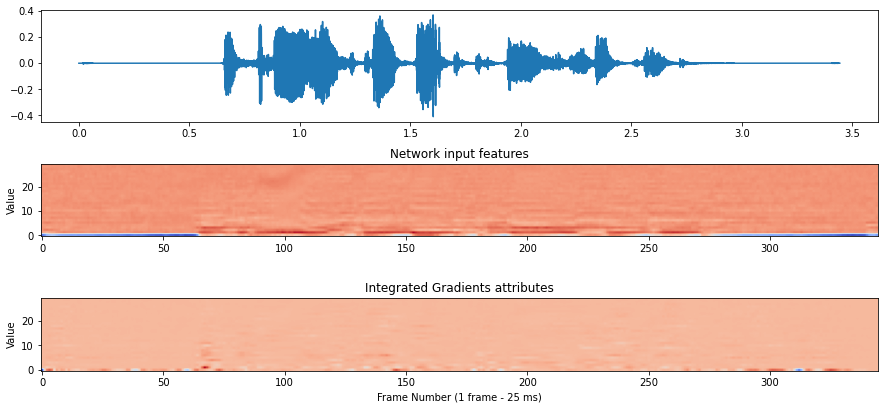

wav_teens.npy mfcc_teens.npy
network prediction: [[ 20.654076  -31.3273      4.5192676   4.5692606   2.073344   -2.200029
   -1.350956    3.079873 ]]
predicted: ['teens'], real class: teens


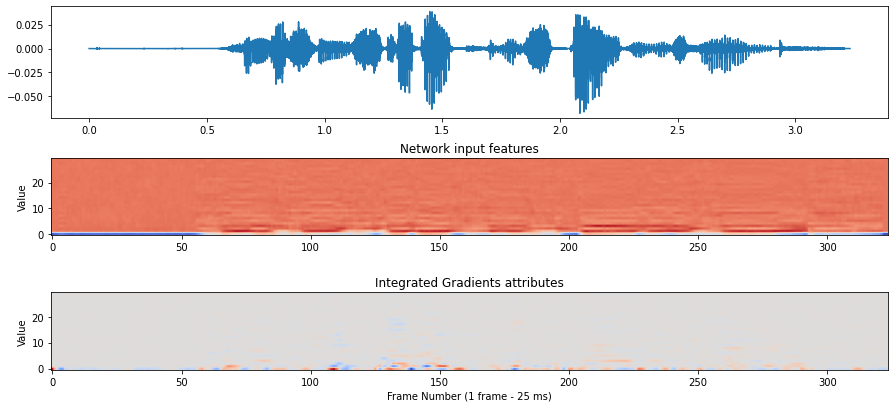

wav_thirties.npy mfcc_thirties.npy
network prediction: [[-1.5307438  4.9477673  4.0075674  6.3581276  2.9189606 -5.9822855
  -8.295762  -2.422224 ]]
predicted: ['fourties'], real class: thirties


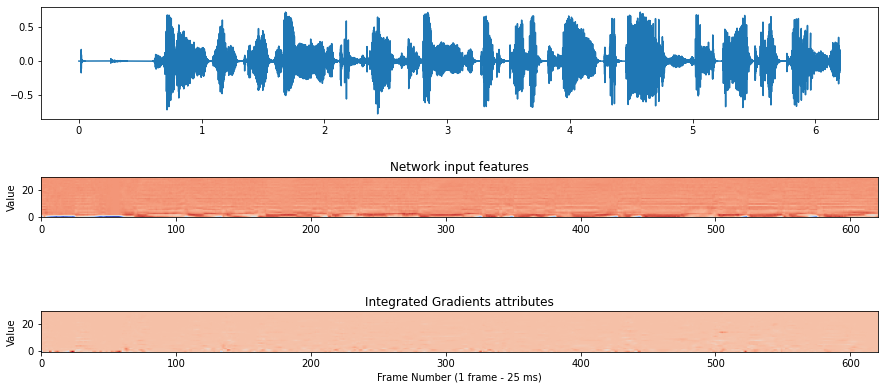

wav_twenties.npy mfcc_twenties.npy
network prediction: [[  3.7732146   14.529268    -3.2628074  -12.079282    -3.727316
    5.814519    -5.0114594   -0.03693603]]
predicted: ['twenties'], real class: twenties


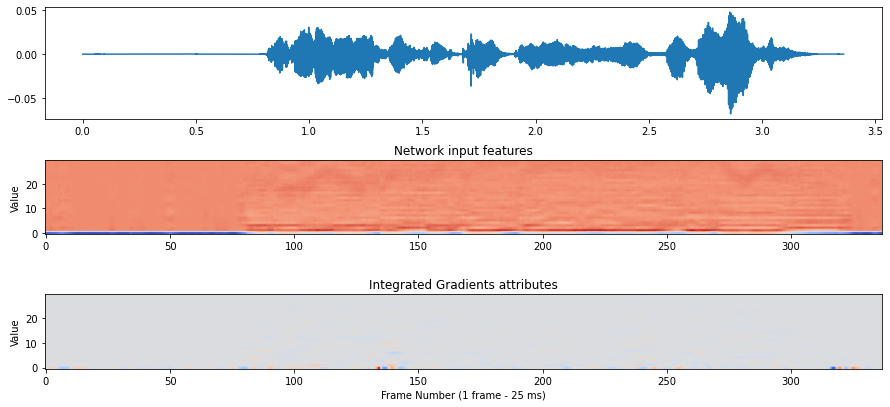

wav_eighties.npy mfcc_eighties.npy
network prediction: [[ 3.0646107   0.8872832  -2.4843242  -1.4130279  -5.3649225  -0.03986621
   2.8079686   2.5553827 ]]
predicted: ['teens'], real class: eighties


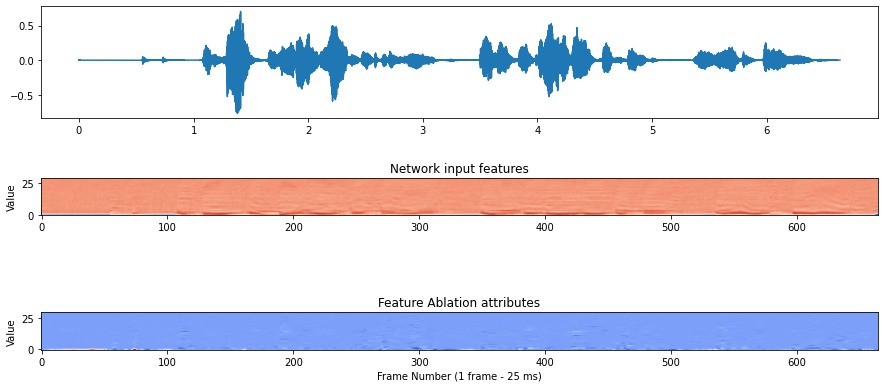

wav_fifties.npy mfcc_fifties.npy
network prediction: [[  0.33479452 -49.401745    11.8042965   -4.1163297   37.033962
   -0.7913718    3.026516     2.1084814 ]]
predicted: ['fifties'], real class: fifties


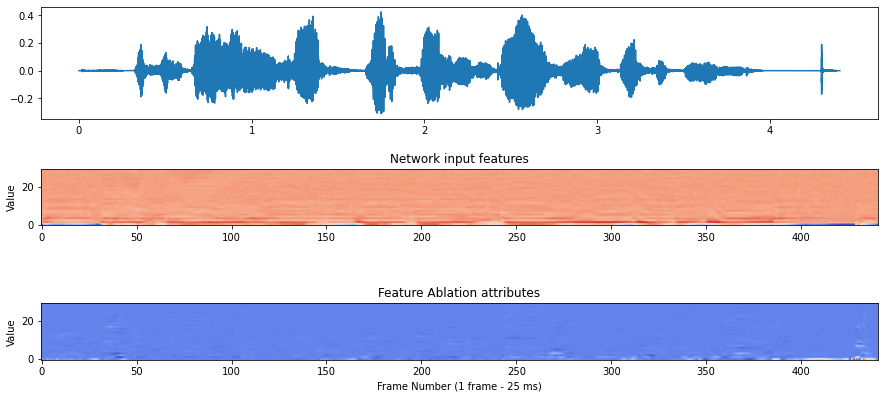

wav_fourties.npy mfcc_fourties.npy
network prediction: [[ -9.902435   -7.973635   -8.739233   40.352825   -3.5192795 -13.082677
    5.507105   -2.6514864]]
predicted: ['fourties'], real class: fourties


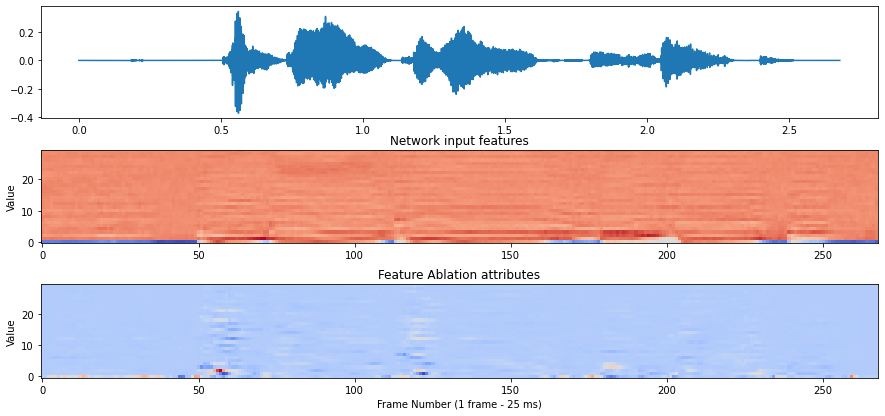

wav_seventies.npy mfcc_seventies.npy
network prediction: [[ 10.329803   -25.87305    -37.03365      0.33786795 -13.011906
    6.6826086   47.669216    10.880729  ]]
predicted: ['seventies'], real class: seventies


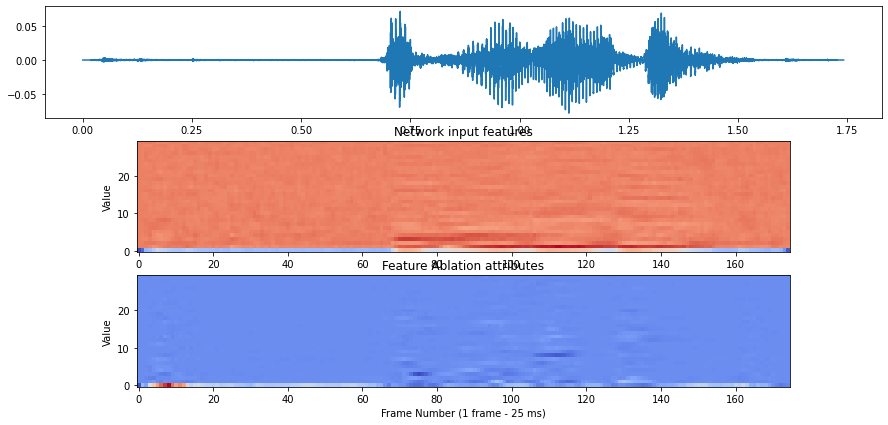

wav_sixties.npy mfcc_sixties.npy
network prediction: [[ -0.6358677  -0.6150241 -14.509293   -2.3809507  -0.9701512  20.12123
   -2.9505682   1.9456484]]
predicted: ['sixties'], real class: sixties


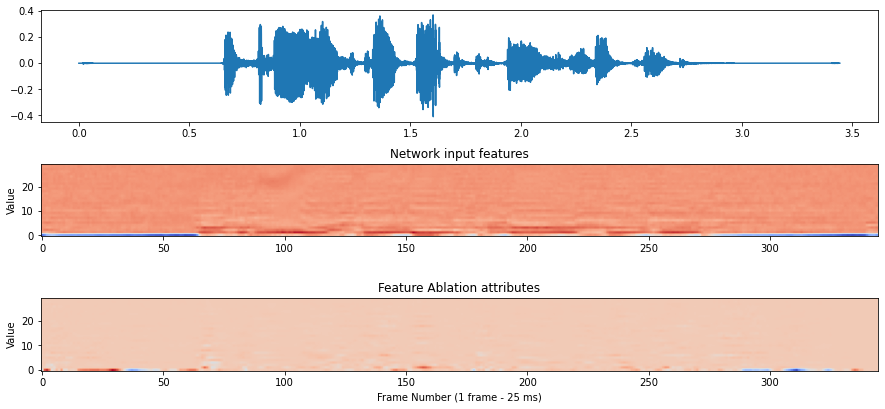

wav_teens.npy mfcc_teens.npy
network prediction: [[ 20.654076  -31.3273      4.5192676   4.5692606   2.073344   -2.200029
   -1.350956    3.079873 ]]
predicted: ['teens'], real class: teens


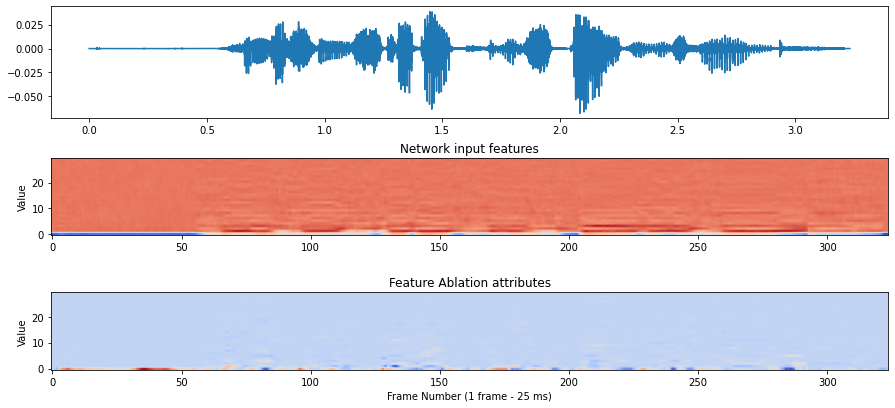

wav_thirties.npy mfcc_thirties.npy
network prediction: [[-1.5307438  4.9477673  4.0075674  6.3581276  2.9189606 -5.9822855
  -8.295762  -2.422224 ]]
predicted: ['fourties'], real class: thirties


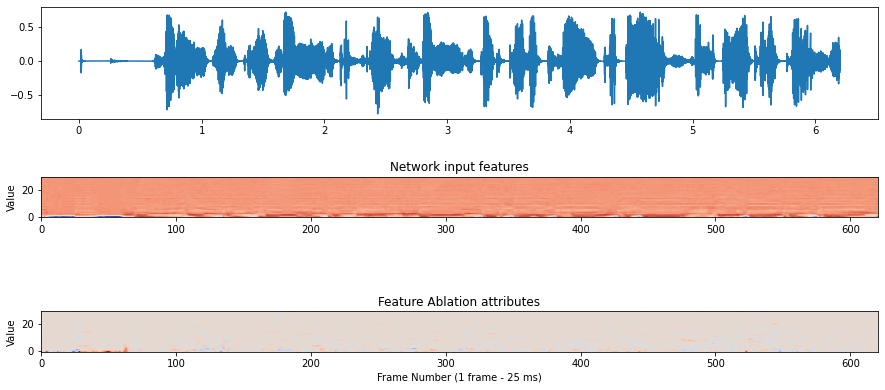

wav_twenties.npy mfcc_twenties.npy
network prediction: [[  3.7732146   14.529268    -3.2628074  -12.079282    -3.727316
    5.814519    -5.0114594   -0.03693603]]
predicted: ['twenties'], real class: twenties


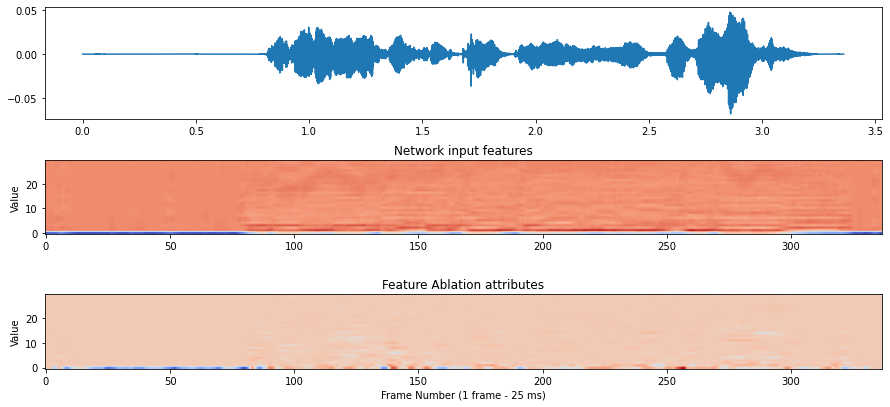

In [16]:
cuda0 = torch.device('cuda:0') 
labels = [
    'teens', 'twenties',  'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'
]
example_id = 0
wavs = sorted(load_wavs(), key=lambda x: x[0])
mfccs = sorted(load_mfccs(), key=lambda x: x[0])
classes = sorted(load_classes(), key=lambda x: x[0])
explain_methods = ['ig', 'fa']
labels_map = dict([(labels[i], i) for i in range(len(labels))])
pytorch_embedder = pytorch_embedder.to(cuda0)
for explain_method in explain_methods:
    for (wav_name, wav), (mfcc_name, mfcc), (class_name, class_) in zip (wavs, mfccs, classes):
        print(wav_name, mfcc_name)
        pytorch_embedder.zero_grad()

        test_input_tensor = torch.FloatTensor(mfcc)
        test_input_tensor = test_input_tensor.to(cuda0)

        with torch.no_grad():
            prediction = pytorch_embedder.forward(test_input_tensor)
            print(f"network prediction: {prediction.detach().cpu().numpy()}")

            real_class = get_real_class(mfcc_name)
            predicted_class = post_process_predictions(prediction.detach(), labels)
            print(f"predicted: {predicted_class}, real class: {real_class}")

        class_label = torch.LongTensor(class_)
        class_label = class_label.to(cuda0)

        if explain_method == 'ig':
            ig = IntegratedGradients(pytorch_embedder)
            test_input_tensor.requires_grad_()        
            attr, delta = ig.attribute(test_input_tensor, target=class_label, return_convergence_delta=True)
            attr = attr.cpu().detach().numpy()
            attribute_plot_title = 'Integrated Gradients attributes'
        elif explain_method == 'fa':
            fa = FeatureAblation(pytorch_embedder)
            attr = fa.attribute(test_input_tensor, target=class_label)
            attr = attr.cpu().detach().numpy()
            attribute_plot_title = 'Feature Ablation attributes'
        else:
            raise ValueError('unrecognized explain method {}'.format(args.explain_method ))

        # plot the results
        fig, axs = plt.subplots(3, 1, sharex=False, sharey=False)
        dpi = 200
        sample_rate = 48000
        axs[0].plot([i/sample_rate for i in range(wav[0].shape[0])], wav[0])

        axs[1].imshow(test_input_tensor.cpu().detach().numpy()[0], cmap=cm.coolwarm, origin='lower')
        axs[1].set_title('Network input features')
        axs[1].set_ylabel('Value')

        axs[2].imshow(attr[0], cmap=cm.coolwarm, origin='lower')
        axs[2].set_title(attribute_plot_title)
        axs[2].set_xlabel('Frame Number (1 frame - 25 ms)')
        axs[2].set_ylabel('Value')
        plt.show()

    #     plt.savefig(os.path.join(args.save_directory, 'explain_matrix_{}_{}.png'.format(real_class, args.explain_method )), dpi=dpi)